## NBA Player Scoring Predictor 


In [139]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans as clustering
 
model = LinearRegression()
logModel = LogisticRegression(max_iter = 100000)

In [2]:
df= pd.read_csv("NBA_Player_Data.csv")
pd.set_option("display.max_columns", None)
df.head()

,Name,age,team_id,lg_id,pos,g,gs,mp_per_g,fg_per_g,fga_per_g,fg_pct,fg3_per_g,fg3a_per_g,fg3_pct,fg2_per_g,fg2a_per_g,fg2_pct,efg_pct,ft_per_g,fta_per_g,ft_pct,orb_per_g,drb_per_g,trb_per_g,ast_per_g,stl_per_g,blk_per_g,tov_per_g,pf_per_g,pts_per_g
0,Jaylen Adams,22,ATL,NBA,PG,34,1,12.6,1.1,3.2,0.345,0.7,2.2,0.338,0.4,1.1,0.361,0.459,0.2,0.3,0.778,0.3,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2
1,Jaylen Adams,24,MIL,NBA,PG,7,0,2.6,0.1,1.1,0.125,0.0,0.3,0.000,0.1,0.9,0.167,0.125,0.0,0.0,0.000,0.0,0.4,0.4,0.3,0.0,0.0,0.0,0.1,0.3
2,Steven Adams,20,OKC,NBA,C,81,20,14.8,1.1,2.3,0.503,0.0,0.0,0.000,1.1,2.3,0.503,0.503,1.0,1.7,0.581,1.8,2.3,4.1,0.5,0.5,0.7,0.9,2.5,3.3
3,Steven Adams,21,OKC,NBA,C,70,67,25.3,3.1,5.7,0.544,0.0,0.0,0.000,3.1,5.7,0.547,0.544,1.5,2.9,0.502,2.8,4.6,7.5,0.9,0.5,1.2,1.4,3.2,7.7
4,Steven Adams,22,OKC,NBA,C,80,80,25.2,3.3,5.3,0.613,0.0,0.0,0.000,3.3,5.3,0.613,0.613,1.4,2.5,0.582,2.7,3.9,6.7,0.8,0.5,1.1,1.1,2.8,8.0


# Cleaning Data 

Dropping uncessary columns from data.

In [3]:
df = df.drop(columns=['team_id','lg_id','gs','g','fg_per_g','fg_pct','fg3_per_g','fg3_pct','fg2_per_g','fg2_pct'
                     ,'efg_pct','ft_per_g','ft_pct'])
df.head()

,Name,age,pos,mp_per_g,fga_per_g,fg3a_per_g,fg2a_per_g,fta_per_g,orb_per_g,drb_per_g,trb_per_g,ast_per_g,stl_per_g,blk_per_g,tov_per_g,pf_per_g,pts_per_g
0,Jaylen Adams,22,PG,12.6,3.2,2.2,1.1,0.3,0.3,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2
1,Jaylen Adams,24,PG,2.6,1.1,0.3,0.9,0.0,0.0,0.4,0.4,0.3,0.0,0.0,0.0,0.1,0.3
2,Steven Adams,20,C,14.8,2.3,0.0,2.3,1.7,1.8,2.3,4.1,0.5,0.5,0.7,0.9,2.5,3.3
3,Steven Adams,21,C,25.3,5.7,0.0,5.7,2.9,2.8,4.6,7.5,0.9,0.5,1.2,1.4,3.2,7.7
4,Steven Adams,22,C,25.2,5.3,0.0,5.3,2.5,2.7,3.9,6.7,0.8,0.5,1.1,1.1,2.8,8.0


This analysis is meant to analyaze how a players scoring will be effected by their minutes. Things like league ID don't tell us anything as all these players play on the same team. Though the team a player plays on may have an effect on their scoring, because we are taking this over several seasons, and the construction of teams varies over that period of time, we will assume that all teams provide an equal chance for scoring improvement of regression. Additionally, other stats like field goal perentage are redundant as they are simply the amount of makes a player has of a type of field goal, divided by the how many they took. The amount of field goals and 3 pointers taken is a valuable piece of information as it describes how a player looks to score

In [4]:
df.loc[df['pos']=='C,PF']


,Name,age,pos,mp_per_g,fga_per_g,fg3a_per_g,fg2a_per_g,fta_per_g,orb_per_g,drb_per_g,trb_per_g,ast_per_g,stl_per_g,blk_per_g,tov_per_g,pf_per_g,pts_per_g
635,Robert Covington,29,"C,PF",30.5,10.3,6.9,3.5,1.8,0.9,5.7,6.6,1.3,1.6,1.3,1.5,3.1,12.4
694,Ed Davis,23,"C,PF",20.1,6.0,0.0,6.0,2.1,1.9,3.8,5.7,0.8,0.5,1.0,0.8,2.4,7.7
990,Daniel Gafford,22,"C,PF",14.6,4.2,0.0,4.2,2.0,1.7,2.5,4.3,0.5,0.5,1.4,0.8,1.8,7.0
1181,Jeff Green,33,"C,PF",20.0,7.2,3.8,3.4,1.9,0.5,2.3,2.8,1.0,0.5,0.4,0.9,1.9,9.4
1204,Donta Hall,22,"C,PF",14.8,2.4,0.0,2.4,2.0,1.6,2.7,4.2,0.4,0.3,0.7,0.6,2.6,4.3
1648,James Johnson,32,"C,PF",19.3,6.7,2.8,3.9,1.5,0.8,2.9,3.7,2.3,0.8,1.0,1.5,2.5,8.4
1778,Luke Kornet,25,"C,PF",11.2,3.3,1.9,1.4,0.2,0.5,1.7,2.2,0.8,0.1,1.0,0.2,0.6,3.4
1950,Thon Maker,21,"C,PF",15.2,4.2,2.4,1.8,1.3,0.6,2.5,3.2,0.7,0.3,0.8,0.5,1.6,5.0
2315,Kelly Olynyk,29,"C,PF",28.5,10.0,5.3,4.7,2.5,1.2,5.7,7.0,2.9,1.1,0.6,1.8,3.0,13.5


## Creating and adding dummy variables for position

In [5]:
def remove_extra_positions(val):
    if val =='C,PF':
        
        return 'PF'
    elif val== "PF,SF":
        return "SF"
    elif val=="PG,SG":
        return "PG"
    elif val=="SF,SG":
        return "SG"
    else:
        return val


Because basketball players can play several positions, such as a shooting guard playing point guard and vice versa, we must set their position to one value for the purposes of consitency. Positions are ordered 1-5 where the 1 is the point guard, 2 is the shooting guard, 3 is the small forward, 4 is a power forward, and 5 is a center. Typically, the position a player plays has an effect on other statistics such as how much they rebound, score and assist. For this, if a player is considered for 2 positions, they will be moved back to the position of the lesser value so a player who plays shooting guard and point guard will be consdered and point guard, a player playing center and power forward will be considered a power forward and so on. 

In [6]:
#Check if exrtra variables are there
df['pos'] = df['pos'].apply(lambda x:remove_extra_positions(x))
df['pos'].unique()

array(['PG', 'C', 'PF', 'SG', 'SF'], dtype=object)

In [7]:
#combind the data frames
dummies = pd.get_dummies(df.pos)
df = pd.concat([df,dummies],axis=1)     

In [8]:
#dropping extra columns 
df = df.drop(columns=['C','pos'])
df.head()

,Name,age,mp_per_g,fga_per_g,fg3a_per_g,fg2a_per_g,fta_per_g,orb_per_g,drb_per_g,trb_per_g,ast_per_g,stl_per_g,blk_per_g,tov_per_g,pf_per_g,pts_per_g,PF,PG,SF,SG
0,Jaylen Adams,22,12.6,3.2,2.2,1.1,0.3,0.3,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2,0,1,0,0
1,Jaylen Adams,24,2.6,1.1,0.3,0.9,0.0,0.0,0.4,0.4,0.3,0.0,0.0,0.0,0.1,0.3,0,1,0,0
2,Steven Adams,20,14.8,2.3,0.0,2.3,1.7,1.8,2.3,4.1,0.5,0.5,0.7,0.9,2.5,3.3,0,0,0,0
3,Steven Adams,21,25.3,5.7,0.0,5.7,2.9,2.8,4.6,7.5,0.9,0.5,1.2,1.4,3.2,7.7,0,0,0,0
4,Steven Adams,22,25.2,5.3,0.0,5.3,2.5,2.7,3.9,6.7,0.8,0.5,1.1,1.1,2.8,8.0,0,0,0,0


The way dummy variables work is that a value of 1 to 0 is assigned to the position that a player has. Since the position a player plays is mutually exclusive it means they will only have a value of 1 for only one of the values in the parameters for position. Since there exists a scenario where if 4 of the values are 0, the position the player is must be position not labled 0. This means that we can drop one of the dummy variables and when the player is playing that particular position that was droppped, fill all the other values with 0 to imply that they are in that position. In this case we dropped the center position, so any player with the value of center will simply have [0,0,0,0] coresspoing to the values of [PG,SG,SF,PF].

0 0
0 1
1 0
1 1


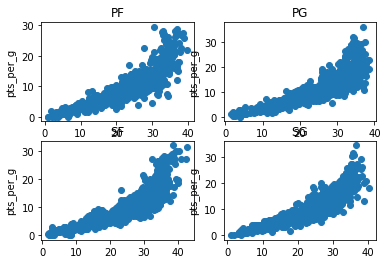

In [9]:
figure, axis = plt.subplots(2, 2)
axisIndex= 0
pos_list = ['PF','PG','SF','SG']
X = np.arange(0, math.pi*2, 0.05)
Y1 = np.sin(X)
Y2 = np.cos(X)
Y3 = np.tan(X)
Y4 = np.tanh(X)

# axis[0, 0].plot(X, Y1)
# axis[0, 0].set_title("Sine Function")
  
# # For Cosine Function
# axis[0, 1].plot(X, Y2)
# axis[0, 1].set_title("Cosine Function")
  
# # For Tangent Function
# axis[1, 0].plot(X, Y3)
# axis[1, 0].set_title("Tangent Function")
  
# # For Tanh Function
# axis[1, 1].plot(X, Y4)
# axis[1, 1].set_title("Tanh Function")

for i in pos_list:
    print(axisIndex//2,axisIndex%2)
    col = df[df[i]==1]
    axis[axisIndex//2][axisIndex%2].scatter(col['mp_per_g'],col['pts_per_g'])
    axis[axisIndex//2][axisIndex%2].set_xlabel =('mp_per_g')
    axis[axisIndex//2][axisIndex%2].set_ylabel('pts_per_g')
    axis[axisIndex//2][axisIndex%2].set_title(i)
   
    axisIndex+=1
    
#     plt.show()

When creating a scatter plot representing the minutes versus scoring among different players in different seasons, there seems to be no noticeable difference in the trends between positions. Thus we can eliminate positions as one of the variables wihin our linear regression 

In [10]:
df = df.drop(columns=['PG','SF','PF','SG'])
df.head(1)

,Name,age,mp_per_g,fga_per_g,fg3a_per_g,fg2a_per_g,fta_per_g,orb_per_g,drb_per_g,trb_per_g,ast_per_g,stl_per_g,blk_per_g,tov_per_g,pf_per_g,pts_per_g
0,Jaylen Adams,22,12.6,3.2,2.2,1.1,0.3,0.3,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2


In [11]:
df['ppg_added']= 0
df['mpg_added']= 0 
df['Final_name'] = False
indexToDelete = 0
for i in range(0,len(df)-1):
    if (df.iloc[i+1,0]==df.iloc[i,0]):
        df['ppg_added'][i] = df['pts_per_g'][i+1]-df['pts_per_g'][i]
        df['mpg_added'][i] = df['mp_per_g'][i+1]-df['mp_per_g'][i]
    else:
        df['Final_name'][i-1] = True


<ipython-input-11-fea656c26132>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ppg_added'][i] = df['pts_per_g'][i+1]-df['pts_per_g'][i]
<ipython-input-11-fea656c26132>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mpg_added'][i] = df['mp_per_g'][i+1]-df['mp_per_g'][i]
<ipython-input-11-fea656c26132>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Final_name'][i-1] = True


A new column was added that was supposed to represent how much a player's scoring improved based on the amount of minutes they had gotten or lost from the last to the current season 

In [12]:
df.drop(df[df['Final_name'] == True].index, inplace = True)
df = df.drop(columns='Final_name')
df.head()

,Name,age,mp_per_g,fga_per_g,fg3a_per_g,fg2a_per_g,fta_per_g,orb_per_g,drb_per_g,trb_per_g,ast_per_g,stl_per_g,blk_per_g,tov_per_g,pf_per_g,pts_per_g,ppg_added,mpg_added
1,Jaylen Adams,24,2.6,1.1,0.3,0.9,0.0,0.0,0.4,0.4,0.3,0.0,0.0,0.0,0.1,0.3,0,0
2,Steven Adams,20,14.8,2.3,0.0,2.3,1.7,1.8,2.3,4.1,0.5,0.5,0.7,0.9,2.5,3.3,4,10
3,Steven Adams,21,25.3,5.7,0.0,5.7,2.9,2.8,4.6,7.5,0.9,0.5,1.2,1.4,3.2,7.7,0,0
4,Steven Adams,22,25.2,5.3,0.0,5.3,2.5,2.7,3.9,6.7,0.8,0.5,1.1,1.1,2.8,8.0,3,4
5,Steven Adams,23,29.9,8.2,0.0,8.2,3.2,3.5,4.2,7.7,1.1,1.1,1.0,1.8,2.4,11.3,2,2


## Linear regression 

In [13]:
x = df[['age','mp_per_g','fg3a_per_g','fg2a_per_g','fta_per_g',
         'pts_per_g','mpg_added']]

y  = df['ppg_added']

In [14]:
model.fit(x,y)

LinearRegression()

In [21]:
model.score(x,y)

0.688777772991775

In [24]:
#Putting in Ben Simmon's Rookie year 
model.predict([[21,33.7,0.1,12.2,4.2,15.8,0.5]])

array([1.02896283])

The following prediction which uses Ben Simmon's rookie year as a sample predicted that he would put up 1.0 more points if he got 0.5 more minutes (his minute increase in his Sophmore year. His Sophmore year point increase was 1.1 

## Logistic regression 

In some cases, the rate at which a player is able to score may decrease as they get more minutes due to a variety of factors. Here we'll investigate how a logisitic regression compares to a linear regression 

In [47]:
logModel.fit(x,y)

LogisticRegression(max_iter=100000)

In [48]:
logModel.score(x,y)

0.44845173041894354

In [49]:
logModel.predict([[21,33.7,0.1,12.2,4.2,15.8,0]])

array([0])

The model score is not as high as the linear regression 

## Clustering different roles to identify improvement

Some players come under different roles. Low scoring players who are designated as "role players" will be less likely to score more if they get more minutes due to the limitaitons of their role. However, stars (who are focal points of offenses) may get oppurtunities at a higher rate with more minutes. Thus, it would make sense to cluster players based on their role, and classify them based on that 

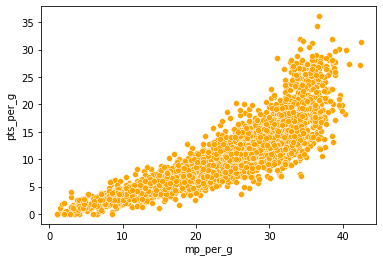

In [69]:
_ = sns.scatterplot(x = df['mp_per_g'], y= df['pts_per_g'],color='orange')

Since basketball has become more so "positionless", and as shown earlier, grouping players by position seems to have little to no effect on scoring given more minutes, we could try to create several clusters based on their roles. In this case we will be using k-means clustering to classify what role a player is in and perform a linear regression on each cluster

In [130]:
playerClusters = KMeans(n_clusters=6, random_state=0)

In [131]:
playerScoringDf = df[['pts_per_g','mp_per_g']]
playerScoringDf.head()

,pts_per_g,mp_per_g
1,0.3,2.6
2,3.3,14.8
3,7.7,25.3
4,8.0,25.2
5,11.3,29.9


In [132]:
playerClusters.fit(playerScoringDf)

KMeans(n_clusters=6, random_state=0)

In [133]:
playerClusters.score(playerScoringDf)

-24264.097159687448

In [137]:
playerClusters.cluster_centers_

array([[ 7.62709091, 20.81218182],
       [23.61788321, 35.4310219 ],
       [ 2.43067093,  7.40638978],
       [15.58838095, 32.41580952],
       [11.17605863, 27.08403909],
       [ 5.16673774, 14.75522388]])

<AxesSubplot:>

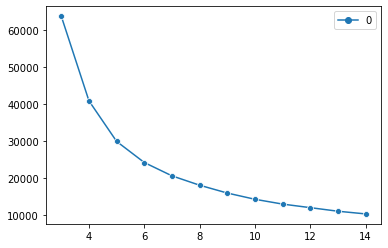

In [142]:
inertia  = []
for i in range(3,15):
    kmeans = clustering(n_clusters=i, random_state=0)
    kmeans.fit(playerScoringDf)
    inertia.append(kmeans.inertia_)
kmeans_df = pd.DataFrame(inertia,range(3,15))
sns.lineplot(data = kmeans_df,markers=True)


The elbow of this plot seems to be with 6 clusters. So we will use 6 clusters for the purpose of this 

In [156]:
playerClusters = KMeans(n_clusters=6, random_state=0)

In [157]:
playerScoringDf = df[['mp_per_g','pts_per_g']]
playerScoringDf.head()

,mp_per_g,pts_per_g
1,2.6,0.3
2,14.8,3.3
3,25.3,7.7
4,25.2,8.0
5,29.9,11.3


In [158]:
playerClusters.fit(playerScoringDf)

KMeans(n_clusters=6, random_state=0)

In [159]:
playerClusters.score(playerScoringDf)

-24264.09715968745

In [160]:
playerClusters.cluster_centers_

array([[32.41580952, 15.58838095],
       [14.75522388,  5.16673774],
       [20.81218182,  7.62709091],
       [35.4310219 , 23.61788321],
       [ 7.40638978,  2.43067093],
       [27.08403909, 11.17605863]])